# **SARIMAX MODEL**

## **Libraries**

In [1]:
# Install libraries
%pip install seaborn
%pip install pmdarima
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import time

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 9, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.7 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## **Functions**

### **def check_stationarity()**

In [2]:
# This function tests if a time series is stationary

def check_stationarity(ts, name="series"):
    df_test = adfuller(ts) #Runs ADF test for stationarity
    adf = df_test[0] # Test statistic
    pvalue = df_test[1] # if pvalue < 0.05 reject H0 (The series is non-stationary)
    critical_value = df_test[4]["5%"]
    if (pvalue < 0.05) and (adf < critical_value):
        print(f"The {name} series is stationary")
    else:
        print(f"The {name} series is not stationary")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 11, Finished, Available, Finished)

### **def differencing()**

In [3]:
# This function makes the series differenciated and plots

def differencing(diff, name="series"):
    diff_data = diff.diff().dropna()
    diff_data.plot(title=f"Differenciated Series {name}")
    plt.show()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 12, Finished, Available, Finished)

### **def check_diff()**

In [4]:
# This function checks again if the series is differenciated

def check_diff(diff_df, name="series"):
    diff_data = diff_df.diff().dropna() # apply diff and dropna to remove na on first row
    df_test = adfuller(diff_data) #Runs ADF test for stationarity
    adf = df_test[0] # Test statistic
    pvalue = df_test[1] # if pvalue < 0.05 reject H0 (The series is non-stationary)
    critical_value = df_test[4]["5%"]
    if (pvalue < 0.05) and (adf < critical_value):
        print(f"The {name} series is stationary")
    else:
        print(f"The {name} series is not stationary")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 13, Finished, Available, Finished)

### **def auto_partial_corr()**

In [5]:
# This function plot auto & partial autocorrelation for each hierarchy df:

def auto_partial_corr(df, name="series"):
    diff_df = df.diff().dropna()
    plot_acf(diff_df, title=f"Autocorrelation {name}")
    plot_pacf(diff_df, title=f"Partial Autocorrelation {name}")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 14, Finished, Available, Finished)

### **def train_test_split()**

In [6]:
# This function creates train_test split to each hierarchy

def train_test_split(y, X, name="series"):
    y_train = y.iloc[:-4] # y_train data without the last 4 weeks
    y_test = y.iloc[-4:] # y_test data with the last 4 weeks
    X_train = X.iloc[:-4] # X_train data without the last 4 weeks
    X_test = X.iloc[-4:] # X_test data with the last 4 weeks

    print(f"DataFrame {name} train/test split done")
    print("\tX_train:",len(X_train)) #check how many observations on X_train set
    print("\tX_test:",len(X_test)) #check how many observations on X_test set
    print("\ty_train:",len(y_train)) #check how many observations on y_train set
    print("\ty_test:",len(y_test)) #check how many observations on y_test set
    print("\tLast Obs. X_train set",X_train.index.max()) #check last observations on train set
    print("\tFirst Obs. X_test set",X_test.index.min()) #check first observations on test set

    return y_train, y_test, X_train, X_test

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 15, Finished, Available, Finished)

### **def timeseries_cv()**

In [7]:
def timeseries_cv(y, X, n_splits=5, name="series"):
    tscv = TimeSeriesSplit(n_splits=n_splits) # 5fold splits

    y_train, y_test, X_train, X_test = [], [], [], []

    for train_index, test_index in tscv.split(y):
        tscv_y_train = y.iloc[train_index] 
        tscv_y_test = y.iloc[test_index]
        tscv_X_train  = X.iloc[train_index] 
        tscv_X_test = X.iloc[test_index]

        print(f"\nFold for {name}")
        print("  y_train:", len(tscv_y_train))
        print("  y_test:", len(tscv_y_test))
        print("  X_train:", len(tscv_X_train))
        print("  X_test:", len(tscv_X_test))
        print("  Last Obs. X_train set:", tscv_X_train.index.max())
        print("  First Obs. X_test set:", tscv_X_test.index.min())

        y_train.append(tscv_y_train)
        y_test.append(tscv_y_test)
        X_train.append(tscv_X_train)
        X_test.append(tscv_X_test)

    return y_train, y_test, X_train, X_test


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 16, Finished, Available, Finished)

### **def evaluate_sarimax_model()**

In [8]:
# Creation of a SARIMAX model and mae evaluation
def evaluate_sarimax_model(y_train, y_test, X_train, X_test, order, seasonal_order): 
    try:
        #Fit Sarimax on training data
        sx_model = SARIMAX(
            endog=y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results_sxmodel = sx_model.fit(disp=False)

        #Forecast the same number of weeks as in test set
        forecast_sxmodel = results_sxmodel.forecast(steps=len(y_test), exog=X_test)

        #Evaluate forecast_grid against the true values
        mae_sxmodel = mean_absolute_error(y_test, forecast_sxmodel)
        return mae_sxmodel, results_sxmodel, forecast_sxmodel
    except Exception as e:
        print("SARIMAX fitting failed with error:", e)
        return float("inf"), None, None


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 17, Finished, Available, Finished)

### **def tune_sarimax_model()**

In [9]:
# Sarimax Manual Hyperparameter tuning (Find the best parameters)
def tune_sarimax_model(
    y_train,
    y_test,
    X_train,
    X_test,
    #Example of parameters to test given PACF and ACF
    p_values=[0, 1, 2], 
    d_values=[1], 
    q_values=[0, 1], 
    P_values=[0, 1], 
    D_values=[1], 
    Q_values=[0, 1], 
    s=52, #weekly, assumes yearly sazonality
    name="series"
):
    best_mae = float("inf")
    best_parameters = None
    # For loop to run the order and seasonal parameters
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                # SARIMAX model implementation
                                sxmodel_grid = SARIMAX(
                                    endog=y_train, # ["weekly_sales"] Target variable
                                    exog=X_train, # [exog_cols] Exogenous variables
                                    order=order, #(p, d, q)
                                    seasonal_order=seasonal_order, #(P, D, Q, s)
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                )
                                results_sxmodel_grid = sxmodel_grid.fit(disp=False) # fit the model
                                forecast_sxgrid = results_sxmodel_grid.forecast(steps=len(y_test), exog=X_test) # selection of time to forecast (4 weeks)
                                mae = mean_absolute_error(y_test, forecast_sxgrid) # get mean absolute error
                                print(f"SARIMAX{order}x{seasonal_order} - MAE: {mae:.2f}")
                                if mae < best_mae: 
                                    best_mae = mae # selects the lower mae since best_mae will always be greater since its "inf"
                                    best_parameters = (order, seasonal_order) # selects the best mae
                            except: # in case of error the model does not stop
                                print(f" Failed for SARIMAX{order}x{seasonal_order}")
                                continue

    print(f"\n Best SARIMAX config for {name}: {best_parameters} with MAE = {best_mae:.2f}")
    return best_parameters, best_mae, forecast_sxgrid, results_sxmodel_grid


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 18, Finished, Available, Finished)

### **def plt_forecast_actuals()**

In [10]:
# Creation of a funtion to plot Forecast vs actual values
def plt_forecast_actuals(y_train, y_test, forecast_sxmodel, forecast_sxgrid, name="series"):
    plt.figure(figsize=(10, 4))
    plt.plot(y_train.index, y_train, label="Train")
    plt.plot(y_test.index, y_test, label="Test")
    plt.plot(y_test.index, forecast_sxmodel, label="Forescast_SARIMAX_model")
    plt.plot(y_test.index, forecast_sxgrid, label="Forecast_SARIMAX_Grid")
    plt.title(f"SARIMAX Forecast vs Actuals {name}")
    plt.legend()
    plt.show()


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 19, Finished, Available, Finished)

## **Load Tables**

In [11]:
# Load tables
df = spark.read.table("ML_Area_.features.features_table")
df.show()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 20, Finished, Available, Finished)

+--------+----------+----+----+-------------------+------------------+------------------+----------------+----------------+-------+-------------------+------------------+-------------------+-------------------+-------------------+--------------+-------------+-------------+----------+-------------+-------------+-------------+-------------+-------------+------------+----------+---------+----------+
|store_id|product_id|year|week|       weekly_sales|         avg_stock|         avg_price|promo_bin_1_rate|promo_bin_2_rate|num_obs|       holiday_rate|      weekend_rate|       lag_sales_1w|       lag_sales_2w|       lag_sales_3w|product_length|product_depth|product_width|cluster_id|hierarchy1_id|hierarchy2_id|hierarchy3_id|hierarchy4_id|hierarchy5_id|storetype_id|store_size|city_name|week_start|
+--------+----------+----+----+-------------------+------------------+------------------+----------------+----------------+-------+-------------------+------------------+-------------------+----------

## **Convert to Pandas**

In [12]:
#To able to manipulate the data, conversion to pandas was made
features_table = df.toPandas()
features_table.head()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 21, Finished, Available, Finished)

,store_id,product_id,year,week,weekly_sales,avg_stock,avg_price,promo_bin_1_rate,promo_bin_2_rate,num_obs,...,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_name,week_start
0,S0002,P0001,2017,4,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-01-22
1,S0002,P0001,2017,5,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-01-29
2,S0002,P0001,2017,6,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-05
3,S0002,P0001,2017,7,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-12
4,S0002,P0001,2017,8,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-19


## **Filter Hierarchy & Store**

### **features_table_all**

In [13]:
features_table.head()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 22, Finished, Available, Finished)

,store_id,product_id,year,week,weekly_sales,avg_stock,avg_price,promo_bin_1_rate,promo_bin_2_rate,num_obs,...,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_name,week_start
0,S0002,P0001,2017,4,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-01-22
1,S0002,P0001,2017,5,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-01-29
2,S0002,P0001,2017,6,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-05
3,S0002,P0001,2017,7,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-12
4,S0002,P0001,2017,8,0.0,1.0,6.5,0.0,0.0,7,...,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,Adana,2017-02-19


**Comments:**
- Features table h02 contains fewer observations in comparison with other Hierarchies

## **Modelling Tables**

### **features_table_model_full_dataset**

In [14]:

features_table_model = (round(features_table
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "sum", # avg_stock for the week
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # avg_price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "sum", # sales from one week prior
            "lag_sales_2w": "sum", # sales from two weeks prior
            "lag_sales_3w": "sum", # sales from three weeks prior
       })
       .rename(columns={"product_id": "n_unique_products"}),
       2
    )
    .reset_index()
)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 23, Finished, Available, Finished)

In [15]:
features_table_model.head()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 24, Finished, Available, Finished)

,week_start,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,n_unique_products,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
0,2017-01-22,3965.79,114900.13,0.0,0.0,62671.31,306,31.19,0.0,0.28,5107.72,4157.01,3922.33
1,2017-01-29,6061.41,114219.14,0.0,0.0,64262.87,310,31.18,0.0,0.29,4029.72,5190.19,4230.99
2,2017-02-05,6311.32,118100.72,0.0,0.0,65467.81,310,31.20,0.0,0.28,6191.40,4182.64,5317.12
3,2017-02-12,4174.46,117383.20,0.0,0.0,65316.48,308,31.14,0.0,0.29,6299.46,6194.09,4190.06
4,2017-02-19,7885.48,115136.77,0.0,0.0,65653.35,308,31.15,0.0,0.28,4197.24,6317.33,6228.39


In [16]:
features_table_model_mod = (round(features_table
       .groupby(["store_id","product_id", "week_start"])[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "sum", # avg_stock for the week
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # avg_price in the week
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "sum", # sales from one week prior
            "lag_sales_2w": "sum", # sales from two weeks prior
            "lag_sales_3w": "sum", # sales from three weeks prior
       }),
        2
    )
    .reset_index()
    .sort_values("week_start")
)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 25, Finished, Available, Finished)

In [17]:
features_table_model_mod.head()

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 26, Finished, Available, Finished)

,store_id,product_id,week_start,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
0,S0002,P0001,2017-01-22,0.00,1.00,0.0,0.0,6.50,39.0,0.0,0.29,0.29,0.43,0.29
961233,S0102,P0051,2017-01-22,2.29,22.86,0.0,0.0,0.70,27.0,0.0,0.29,1.57,1.17,0.14
122043,S0015,P0459,2017-01-22,1.14,30.29,0.0,0.0,3.15,19.0,0.0,0.29,1.86,1.43,1.00
961137,S0102,P0046,2017-01-22,0.00,7.00,0.0,0.0,34.50,27.0,0.0,0.29,0.00,0.00,0.00
960780,S0102,P0035,2017-01-22,0.83,1.17,0.0,0.0,2.95,27.0,0.0,0.17,1.14,0.86,0.57


## **Stationarity, Diff, ACF PACF** 

### **Check Stationarity** 

In [18]:
check_stationarity(features_table_model["weekly_sales"].values, name="Full_dataset")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 27, Finished, Available, Finished)

The Full_dataset series is stationary


### **Differencing** 

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 28, Finished, Available, Finished)

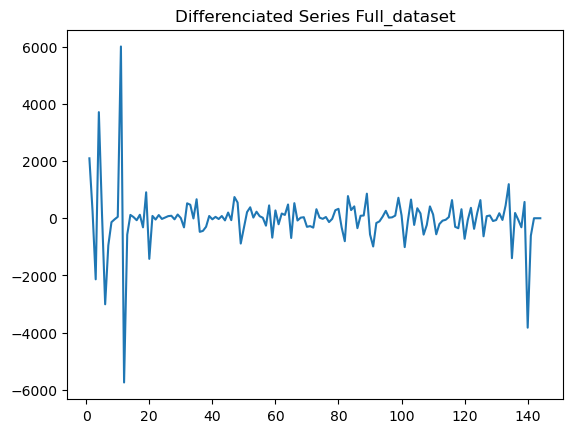

In [19]:
differencing(features_table_model["weekly_sales"], name="Full_dataset")

In [20]:
# Checking again after diff:
check_diff(features_table_model['weekly_sales'], name="Full_dataset")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 29, Finished, Available, Finished)

The Full_dataset series is stationary


### **Auto & Partial Correlation**

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 30, Finished, Available, Finished)

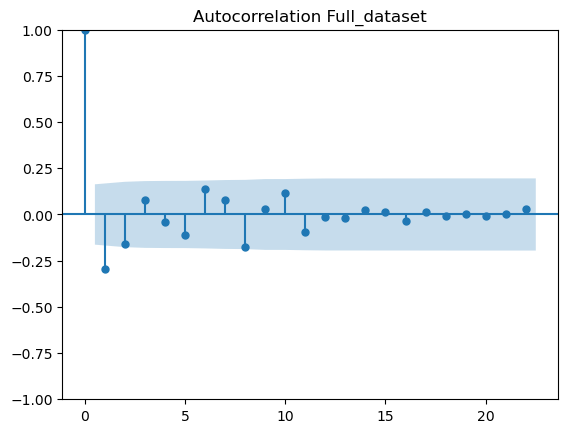

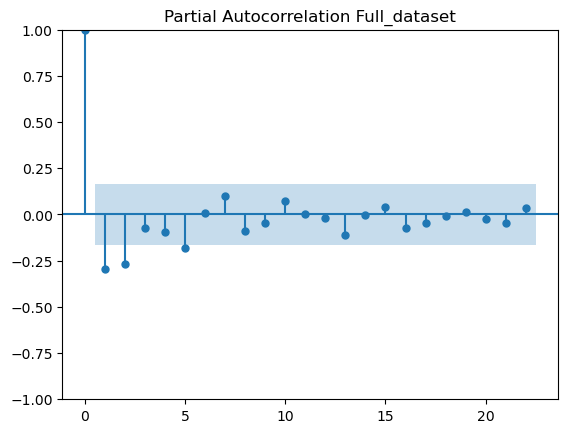

In [21]:
auto_partial_corr(features_table_model["weekly_sales"], name="Full_dataset")

### **Set Parameters**

In [22]:
# After checking diff and ACF and PACF - Setting a start values for order and seasonal_orders
order = (0, 1, 1)
seasonal_order = (0, 0, 0, 52)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 31, Finished, Available, Finished)

### **Exogenous Selection**

#### **Exogenous Correlations All Dataset**

In [23]:
numeric_df = features_table_model.select_dtypes(include=["number"])

print(f"Full_Dataset\n", numeric_df.corr()["weekly_sales"].sort_values(ascending=False))
# Check correlation between ["weekly_sales"] and exogenous features

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 32, Finished, Available, Finished)

Full_Dataset
 weekly_sales         1.000000
avg_stock            0.640315
lag_sales_1w         0.623293
lag_sales_2w         0.453586
lag_sales_3w         0.385207
weekend_rate         0.298845
holiday_rate        -0.167107
avg_price           -0.196423
n_unique_products   -0.211644
store_size          -0.234711
promo_bin_1_rate          NaN
promo_bin_2_rate          NaN
Name: weekly_sales, dtype: float64


#### **Exogenous Features**

In [24]:
exog_cols = [
    "avg_stock",
    "lag_sales_1w",
    "lag_sales_2w",
    "lag_sales_3w",
#    "weekend_rate",
#    "holiday_rate",
#    "n_unique_products",
#    "avg_price",
#    "store_size"
    ]

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 33, Finished, Available, Finished)

#### **features_table_all***

In [25]:
full_y_train, full_y_test, full_X_train, full_X_test = train_test_split(features_table_model["weekly_sales"], features_table_model[exog_cols], name="Fulldata")


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 34, Finished, Available, Finished)

DataFrame Fulldata train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 140
	First Obs. X_test set 141


#### **features_table_all_tscv**

In [26]:
#Run TimeSeries Cross Validation to get folds
#tscv_y_train_folds, tscv_y_test_folds, tscv_X_train_folds, tscv_X_test_folds = timeseries_cv(features_table_model["weekly_sales"], features_table_model[exog_cols], name="Fulldata")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 35, Finished, Available, Finished)

## **SARIMAX** 

### **SARIMAX - Model** 

#### **Full_dataset** 

In [27]:
full_mae_sxmodel, full_results_sxmodel, full_forecast_sxmodel = evaluate_sarimax_model(full_y_train, full_y_test, full_X_train, full_X_test, order, seasonal_order)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 36, Finished, Available, Finished)

### **SARIMAX with TSCV - Model** 

In [28]:
tscv = TimeSeriesSplit(n_splits=5) # 5fold splits
mae_train_scores = []
mae_test_scores = []

for train_index, test_index in tscv.split(features_table_model["weekly_sales"]):
    tscv_y_train = features_table_model["weekly_sales"].iloc[train_index]
    tscv_y_test = features_table_model["weekly_sales"].iloc[test_index]
    tscv_X_train = features_table_model[exog_cols].iloc[train_index]
    tscv_X_test = features_table_model[exog_cols].iloc[test_index]

    sarimax = SARIMAX(
        endog=tscv_y_train, 
        exog=tscv_X_train, 
        order=order, 
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False 
        )
    results_sarimax = sarimax.fit(disp=False)
    # To check overfitting we are going to predict train to compare with test
    # Forescast (training)
    forecasted_train = results_sarimax.forecast(steps=len(tscv_y_train), exog=tscv_X_train)
    train_mae = mean_absolute_error(tscv_y_train, forecasted_train)

    # Forescast (test)
    forecasted_test = results_sarimax.forecast(steps=len(tscv_y_test), exog=tscv_X_test)
    test_mae = mean_absolute_error(tscv_y_test, forecasted_test)

    mae_train_scores.append(train_mae)
    mae_test_scores.append(test_mae)


tscv_train_mae = np.mean(mae_train_scores)
tscv_test_mae = np.mean(mae_test_scores)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 37, Finished, Available, Finished)

### **Hyperparameter Tuning (Manual Grid Search)** 

#### **Full_dataset** 

In [29]:
#best_parameters_full, best_mae_full, forecast_sxgrid_full, results_sxmodel_grid_full = tune_sarimax_model(full_y_train, full_y_test, full_X_train, full_X_test, name="Full_dataset")


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 38, Finished, Available, Finished)

#### **AUTO-SARIMAX with TSCV mae_values** 

**Auto-SARIMAX was used to check the best hyperparameters choosen by the model**

In [30]:
tscv = TimeSeriesSplit(n_splits=5)
mae_train_scores = []
mae_test_scores = []

print("Starting Time Series Cross-Validation with auto_arima...")

# Only the folds with enough data will be used for training
for i, (train_index, test_index) in enumerate(tscv.split(features_table_model["weekly_sales"])):
    tscv_y_train = features_table_model["weekly_sales"].iloc[train_index]

    # --- ADD THIS CONDITION ---
    # Only run the model if the training set is large enough for the seasonality
    if len(tscv_y_train) >= 2 * 52:
        print(f"--- Processing Fold {i+1}/5 (Train size: {len(tscv_y_train)}) ---")
        
        tscv_y_test = features_table_model["weekly_sales"].iloc[test_index]
        tscv_X_train = features_table_model[exog_cols].iloc[train_index]
        tscv_X_test = features_table_model[exog_cols].iloc[test_index]

        auto_sarima = pm.auto_arima(
            y=tscv_y_train,
            X=tscv_X_train,
            m=52,
            seasonal=True,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False
        )
        
        print(f"Best model for fold {i+1}: {auto_sarima.order}x{auto_sarima.seasonal_order}")

        train_predictions = auto_sarima.predict_in_sample(X=tscv_X_train)
        train_mae = mean_absolute_error(tscv_y_train, train_predictions)

        test_predictions = auto_sarima.predict(n_periods=len(tscv_y_test), X=tscv_X_test)
        test_mae = mean_absolute_error(tscv_y_test, test_predictions)

        mae_train_scores.append(train_mae)
        mae_test_scores.append(test_mae)
        print(f"Fold {i+1} -> Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    else:
        print(f"--- Skipping Fold {i+1}/5 (Train size: {len(tscv_y_train)} is too small for m=52) ---")


# Calculate average scores based on the folds that were actually run
if mae_test_scores:
    avg_train_mae = np.mean(mae_train_scores)
    avg_test_mae = np.mean(mae_test_scores)

    print("\n-----------------------------------")
    print(f"Average Train MAE across {len(mae_test_scores)} valid fold(s): {avg_train_mae:.2f}")
    print(f"Average Test MAE across {len(mae_test_scores)} valid fold(s): {avg_test_mae:.2f}")
    print("-----------------------------------")
else:
    print("\nNo folds had sufficient data to run the seasonal model.")

print("-----------------------------------")



StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 39, Finished, Available, Finished)

Starting Time Series Cross-Validation with auto_arima...
--- Skipping Fold 1/5 (Train size: 25 is too small for m=52) ---
--- Skipping Fold 2/5 (Train size: 49 is too small for m=52) ---
--- Skipping Fold 3/5 (Train size: 73 is too small for m=52) ---
--- Skipping Fold 4/5 (Train size: 97 is too small for m=52) ---
--- Processing Fold 5/5 (Train size: 121) ---


Best model for fold 5: (0, 0, 0)x(0, 0, 0, 52)
Fold 5 -> Train MAE: 439.74, Test MAE: 439.34

-----------------------------------
Average Train MAE across 1 valid fold(s): 439.74
Average Test MAE across 1 valid fold(s): 439.34
-----------------------------------
-----------------------------------


### **Check Overfitting/Results** 

#### **Check Overfitting - Full_dataset**

In [ ]:
full_y_train_forecast = full_results_sxmodel.predict(start=full_y_train.index[0], end=full_y_train.index[-1], exog=full_X_train)
full_mae_train = mean_absolute_error(full_y_train, full_y_train_forecast)

full_test_forecast = full_results_sxmodel.forecast(steps=len(full_y_test), exog=full_X_test)
full_mae_test = mean_absolute_error(full_y_test, full_test_forecast)

#### **Results** 

In [32]:
tscv_mae_values = [
    {
        "Method":"Train Test Split",
        "train_mae": full_mae_train,
        "test_mae": full_mae_test,
        "Obs": "✅ Better Generalization!"
    },
    {
        "Method": "Time Series CV",
        "train_mae": tscv_train_mae,
        "test_mae": tscv_test_mae,
        "Obs": "✅ Train/Test Split better!"
    }
    ]



full_dataset_mae_values = round(pd.DataFrame(tscv_mae_values), 2)
full_dataset_mae_values

StatementMeta(, 721cd0d2-b322-45fd-bd91-248577224fab, 41, Finished, Available, Finished)

,Method,train_mae,test_mae,Obs
0,Train Test Split,477.41,347.2,✅ Better Generalization!
1,Time Series CV,859.35,397.2,✅ Train/Test Split better!


### **Final Replenishment Table** 

Creating the final replenishment table and predicting and predicing next week's sales

#### **Top 10 products per Store**

In [35]:
# PARAMETERS
top_n = 10

# Top 10 weekly_sales products
top_products_store = (
    features_table_model_mod.groupby(["store_id", "product_id"])["weekly_sales"]
    .sum()
    .reset_index()
    .sort_values(["store_id", "weekly_sales"], ascending=[True, False])
    .groupby("store_id")
    .head(10)
)

# Apply filter to include only top products
filtered_df = pd.merge(
    features_table_model_mod,
    top_products_store[["store_id", "product_id"]],
    on=["store_id", "product_id"],
    how="inner"
)

forecast_rows = []

latest_week = filtered_df["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)
start = time.time()

grouped = filtered_df.groupby(["store_id", "product_id"])

for i, ((store, product), group) in enumerate(grouped, 1):
    print(f" Forecasting {i} → {store}-{product}")

    if group.shape[0] < 60:
        continue

    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    if y.isna().any() or X.isna().any().any():
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results_model = model.fit(disp=False, maxiter=50)

        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = max(0, forecast.iloc[0])

        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 0),
            "current_stock": round(current_stock, 0),
            "stock_to_order": round(stock_to_order, 0)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue

# Save results
forecast_df = pd.DataFrame(forecast_rows)

print(f"\nForecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)



StatementMeta(, 721cd0d2-b322-45fd-bd91-248577224fab, 44, Submitted, Running, Running)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 3 → S0002-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 5 → S0002-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 9 → S0002-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 13 → S0003-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 15 → S0003-P0333


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 20 → S0003-P0590


 Forecasting 21 → S0005-P0051


 Forecasting 22 → S0005-P0103


 Forecasting 23 → S0005-P0114


 Forecasting 24 → S0005-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 30 → S0005-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 42 → S0010-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 44 → S0010-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 47 → S0010-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 49 → S0010-P0590


 Forecasting 50 → S0010-P0682


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 52 → S0012-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 55 → S0012-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 59 → S0012-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 62 → S0014-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 64 → S0014-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 69 → S0014-P0569


 Forecasting 70 → S0014-P0590


 Forecasting 71 → S0015-P0051


 Forecasting 72 → S0015-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 74 → S0015-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 76 → S0015-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 80 → S0015-P0590


 Forecasting 81 → S0016-P0051


 Forecasting 82 → S0016-P0103


 Forecasting 83 → S0016-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 85 → S0016-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 89 → S0016-P0572


 Forecasting 90 → S0016-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 92 → S0020-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 94 → S0020-P0333


 Forecasting 95 → S0020-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 99 → S0020-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 101 → S0022-P0051


 Forecasting 102 → S0022-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 105 → S0022-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 108 → S0022-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 110 → S0022-P0682


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 115 → S0023-P0333


 Forecasting 116 → S0023-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 124 → S0026-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 128 → S0026-P0438


 Forecasting 129 → S0026-P0500


 Forecasting 130 → S0026-P0569


 Forecasting 131 → S0030-P0051


 Forecasting 132 → S0030-P0103


 Forecasting 133 → S0030-P0296


 Forecasting 134 → S0030-P0333


 Forecasting 135 → S0030-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 137 → S0030-P0436


 Forecasting 138 → S0030-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 140 → S0030-P0590


 Forecasting 141 → S0032-P0051


 Forecasting 142 → S0032-P0103


 Forecasting 143 → S0032-P0185


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 148 → S0032-P0572


 Forecasting 149 → S0032-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 152 → S0036-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 156 → S0036-P0438
 Forecasting 157 → S0036-P0499


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 160 → S0036-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 165 → S0038-P0296


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 170 → S0038-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 172 → S0039-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 175 → S0039-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 179 → S0039-P0569


 Forecasting 180 → S0039-P0572


 Forecasting 181 → S0040-P0051


 Forecasting 182 → S0040-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 184 → S0040-P0333


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 186 → S0040-P0394


 Forecasting 187 → S0040-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 190 → S0040-P0664


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 192 → S0041-P0196


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 197 → S0041-P0569


 Forecasting 198 → S0041-P0590


 Forecasting 199 → S0041-P0663


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 202 → S0045-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 204 → S0045-P0294


 Forecasting 205 → S0045-P0318
 Forecasting 206 → S0045-P0333


 Forecasting 207 → S0045-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 214 → S0046-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 219 → S0046-P0559
 Forecasting 220 → S0046-P0569


 Forecasting 221 → S0050-P0051


 Forecasting 222 → S0050-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 226 → S0050-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 230 → S0050-P0569


 Forecasting 231 → S0052-P0051


 Forecasting 232 → S0052-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 236 → S0052-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 239 → S0052-P0569


 Forecasting 240 → S0052-P0590


 Forecasting 241 → S0055-P0051


 Forecasting 242 → S0055-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 246 → S0055-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 248 → S0055-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 251 → S0056-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 255 → S0056-P0296


 Forecasting 256 → S0056-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 260 → S0056-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 263 → S0058-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 266 → S0058-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 270 → S0058-P0590


 Forecasting 271 → S0059-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 274 → S0059-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 278 → S0059-P0500


 Forecasting 279 → S0059-P0569


 Forecasting 280 → S0059-P0664


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 286 → S0061-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 290 → S0061-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 292 → S0062-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 294 → S0062-P0129


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 296 → S0062-P0348


 Forecasting 297 → S0062-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 300 → S0062-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 305 → S0067-P0372


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 308 → S0067-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 310 → S0067-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 313 → S0068-P0103


 Forecasting 314 → S0068-P0185


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 319 → S0068-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 333 → S0072-P0131


 Forecasting 334 → S0072-P0198


 Forecasting 335 → S0072-P0333


 Forecasting 336 → S0072-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 339 → S0072-P0531


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 341 → S0073-P0017


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 345 → S0073-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 349 → S0073-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 351 → S0076-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 354 → S0076-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 359 → S0076-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 361 → S0077-P0051


 Forecasting 362 → S0077-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 366 → S0077-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 368 → S0077-P0569


 Forecasting 369 → S0077-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 372 → S0080-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 374 → S0080-P0296


 Forecasting 375 → S0080-P0318
 Forecasting 376 → S0080-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 379 → S0080-P0572


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 381 → S0083-P0051


 Forecasting 382 → S0083-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 385 → S0083-P0296


 Forecasting 386 → S0083-P0305
 Forecasting 387 → S0083-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 391 → S0085-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 397 → S0085-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 401 → S0086-P0015


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 403 → S0086-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 408 → S0086-P0499


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 410 → S0086-P0590


 Forecasting 411 → S0088-P0017


 Forecasting 412 → S0088-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 414 → S0088-P0185


 Forecasting 415 → S0088-P0318
 Forecasting 416 → S0088-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 420 → S0088-P0590


 Forecasting 421 → S0089-P0015


 Forecasting 422 → S0089-P0051


 Forecasting 423 → S0089-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 428 → S0089-P0569


 Forecasting 429 → S0089-P0590


 Forecasting 430 → S0089-P0642


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 432 → S0091-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 435 → S0091-P0333


 Forecasting 436 → S0091-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 439 → S0091-P0590


 Forecasting 440 → S0091-P0681


 Forecasting 441 → S0092-P0051


 Forecasting 442 → S0092-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 446 → S0092-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 449 → S0092-P0569
 Forecasting 450 → S0092-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 452 → S0094-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 455 → S0094-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 459 → S0094-P0531


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 461 → S0095-P0131


 Forecasting 462 → S0095-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 467 → S0095-P0531


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 469 → S0095-P0663


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 473 → S0097-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 479 → S0097-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 482 → S0099-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 484 → S0099-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 487 → S0099-P0438


 Forecasting 488 → S0099-P0500


 Forecasting 489 → S0099-P0569


 Forecasting 490 → S0099-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 492 → S0102-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 494 → S0102-P0333


 Forecasting 495 → S0102-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 499 → S0102-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 501 → S0104-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 505 → S0104-P0261


 Forecasting 506 → S0104-P0333


 Forecasting 507 → S0104-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 510 → S0104-P0500


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 512 → S0107-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 515 → S0107-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 520 → S0107-P0590


 Forecasting 521 → S0108-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 527 → S0108-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 531 → S0109-P0051
 Forecasting 532 → S0109-P0103
 Forecasting 533 → S0109-P0116
 Forecasting 534 → S0109-P0131
 Forecasting 535 → S0109-P0311
 Forecasting 536 → S0109-P0318
 Forecasting 537 → S0109-P0333
 Forecasting 538 → S0109-P0388
 Forecasting 539 → S0109-P0569
 Forecasting 540 → S0109-P0590
 Forecasting 541 → S0120-P0051


 Forecasting 542 → S0120-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 544 → S0120-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 548 → S0120-P0569


 Forecasting 549 → S0120-P0572


 Forecasting 550 → S0120-P0590


 Forecasting 551 → S0122-P0017


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 555 → S0122-P0296


 Forecasting 556 → S0122-P0333


 Forecasting 557 → S0122-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 560 → S0122-P0590


 Forecasting 561 → S0126-P0051


 Forecasting 562 → S0126-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 566 → S0126-P0348


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 570 → S0126-P0663


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 580 → S0131-P0590


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 582 → S0132-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 584 → S0132-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 591 → S0136-P0103
 Forecasting 592 → S0136-P0202
 Forecasting 593 → S0136-P0296
 Forecasting 594 → S0136-P0333
 Forecasting 595 → S0136-P0364
 Forecasting 596 → S0136-P0388
 Forecasting 597 → S0136-P0438
 Forecasting 598 → S0136-P0500
 Forecasting 599 → S0136-P0569
 Forecasting 600 → S0136-P0590
 Forecasting 601 → S0141-P0051


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 603 → S0141-P0296


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 606 → S0141-P0438


 Forecasting 607 → S0141-P0499


 Forecasting 608 → S0141-P0572


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 610 → S0141-P0664


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 612 → S0142-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 615 → S0142-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 619 → S0142-P0534


 Forecasting 620 → S0142-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 625 → S0143-P0388


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 629 → S0143-P0569


 Forecasting 630 → S0143-P0590



Forecast complete in 64.98 minutes.


SynapseWidget(Synapse.DataFrame, 2ce01fe0-bf12-4d4a-aec9-6f5b1d5786d7)

#### **Top 10 products H0's**

In [ ]:
# PARAMETERS
top_n = 10
selected_stores = ["S0085", "S0095", "S0080", "S0026"]
#selected_hierarchies = ["H00", "H01", "H02", "H03"]

# Relevant stores and hierarchies
filtered_df = features_table_model_mod[
    (features_table_model_mod["store_id"].isin(selected_stores))
]

# Top 10 weekly_sales products
top_products = (
    filtered_df.groupby("product_id")["weekly_sales"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index
    .tolist()
)

# Apply filter to include only top revenue products
filtered_df = filtered_df[filtered_df["product_id"].isin(top_products)]

forecast_rows = []

latest_week = filtered_df["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)
start = time.time()

grouped = filtered_df.groupby(["store_id", "product_id"])

for i, ((store, product), group) in enumerate(grouped, 1):
    print(f" Forecasting {i} → {store}-{product}")

    if group.shape[0] < 60:
        continue

    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    if y.isna().any() or X.isna().any().any():
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results_model = model.fit(disp=False, maxiter=50)

        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = forecast.iloc[0]

        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 0),
            "current_stock": round(current_stock, 0),
            "stock_to_order": round(stock_to_order, 2)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue

# Save results
forecast_df = pd.DataFrame(forecast_rows)

print(f"\nForecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)



StatementMeta(, 68b2ec63-8e5d-4aaf-8695-5926316af3eb, 47, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 2 → S0026-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 5 → S0026-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 8 → S0026-P0500


 Forecasting 9 → S0026-P0531


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 11 → S0080-P0051


 Forecasting 12 → S0080-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 14 → S0080-P0333


 Forecasting 15 → S0080-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 18 → S0080-P0500


 Forecasting 19 → S0080-P0569


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 24 → S0085-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 28 → S0085-P0531


 Forecasting 29 → S0085-P0569


 Forecasting 30 → S0095-P0051


 Forecasting 31 → S0095-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 33 → S0095-P0333


 Forecasting 34 → S0095-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 38 → S0095-P0531


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)



Forecast complete in 4.72 minutes.


SynapseWidget(Synapse.DataFrame, d261f293-5c55-4c4e-81f5-46920d226fad)

#### **Top 100 Selling Products**

In [35]:
'''
# Top Selling products
top_n = 100
product_sales = features_table_model_mod.groupby("product_id")["weekly_sales"].sum().sort_values(ascending=False)
top_products = product_sales.head(top_n).index.tolist()

# Filter to top products
filtered_df = features_table_model_mod[features_table_model_mod["product_id"].isin(top_products)]

forecast_rows = []

latest_week = filtered_df["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)
start = time.time()

grouped = filtered_df.groupby(["store_id", "product_id"])

for i, ((store, product), group) in enumerate(grouped, 1):
    print(f" Forecasting {i} → {store}-{product}")

    if group.shape[0] < 60:
        continue

    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    if y.isna().any() or X.isna().any().any():
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results_model = model.fit(disp=False, maxiter=50)

        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = forecast.iloc[0]

        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 0),
            "current_stock": round(current_stock, 0),
            "stock_to_order": round(stock_to_order, 2)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue

# Save results
forecast_df = pd.DataFrame(forecast_rows)

print(f"\nForecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)

'''


StatementMeta(, 68b2ec63-8e5d-4aaf-8695-5926316af3eb, 44, Finished, Cancelled, Cancelled)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 3 → S0002-P0035


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 9 → S0002-P0087


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 11 → S0002-P0092


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 13 → S0002-P0110


 Forecasting 14 → S0002-P0114


 Forecasting 15 → S0002-P0116


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 19 → S0002-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 21 → S0002-P0147


 Forecasting 22 → S0002-P0169


 Forecasting 23 → S0002-P0171


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 27 → S0002-P0198


 Forecasting 28 → S0002-P0206


 Forecasting 29 → S0002-P0212


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 31 → S0002-P0260


 Forecasting 32 → S0002-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 35 → S0002-P0277


 Forecasting 36 → S0002-P0280


 Forecasting 37 → S0002-P0286


 Forecasting 38 → S0002-P0296


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 41 → S0002-P0318


 Forecasting 42 → S0002-P0325


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 44 → S0002-P0333


 Forecasting 45 → S0002-P0336


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 51 → S0002-P0394


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 59 → S0002-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 65 → S0002-P0459


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 67 → S0002-P0500


 Forecasting 68 → S0002-P0527


 Forecasting 69 → S0002-P0531


 Forecasting 70 → S0002-P0536


 Forecasting 71 → S0002-P0543


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 74 → S0002-P0559
 Forecasting 75 → S0002-P0565


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 78 → S0002-P0574


 Forecasting 79 → S0002-P0584


 Forecasting 80 → S0002-P0587


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 82 → S0002-P0608


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 84 → S0002-P0639


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 90 → S0002-P0689


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 95 → S0002-P0726


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 98 → S0002-P0747


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 102 → S0003-P0055


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 105 → S0003-P0092
 Forecasting 106 → S0003-P0103


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 110 → S0003-P0129


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 113 → S0003-P0171


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 116 → S0003-P0206


 Forecasting 117 → S0003-P0260


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 121 → S0003-P0286


 Forecasting 122 → S0003-P0296


 Forecasting 123 → S0003-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 136 → S0003-P0428


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 138 → S0003-P0438


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 144 → S0003-P0536


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 147 → S0003-P0559
 Forecasting 148 → S0003-P0569


 Forecasting 149 → S0003-P0572


 Forecasting 150 → S0003-P0590


 Forecasting 151 → S0003-P0639


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 153 → S0003-P0663


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 156 → S0003-P0682


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 158 → S0003-P0694


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 162 → S0003-P0726


 Forecasting 163 → S0005-P0017


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 166 → S0005-P0058
 Forecasting 167 → S0005-P0059
 Forecasting 168 → S0005-P0079


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 172 → S0005-P0114


 Forecasting 173 → S0005-P0116


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 179 → S0005-P0171


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 186 → S0005-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 189 → S0005-P0286


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 191 → S0005-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 193 → S0005-P0325


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 212 → S0005-P0499


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 214 → S0005-P0536


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 220 → S0005-P0569


 Forecasting 221 → S0005-P0572


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 223 → S0005-P0584
 Forecasting 224 → S0005-P0587


 Forecasting 225 → S0005-P0590


 Forecasting 226 → S0005-P0608


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 229 → S0005-P0642


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 Forecasting 300 → S0010-P0055


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 310 → S0010-P0116


 Forecasting 311 → S0010-P0125


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 314 → S0010-P0131


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 317 → S0010-P0169


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 319 → S0010-P0182
 Forecasting 320 → S0010-P0185


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 323 → S0010-P0219


 Forecasting 324 → S0010-P0260


 Forecasting 325 → S0010-P0261


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 330 → S0010-P0286


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 332 → S0010-P0311


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 Forecasting 336 → S0010-P0333


 Forecasting 337 → S0010-P0348


 Forecasting 338 → S0010-P0364


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


#### **Test Sample (5 Products)** 

In [ ]:

#Results storage
forecast_rows = []

#Get latest date to define forecast week
latest_week = features_table_model_mod["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)

#Start Timer
start = time.time()

sample_keys = list(features_table_model_mod.groupby(["store_id", "product_id"]).groups.keys())[:5]

# For loop through each product in each store
#for (store, product), group in features_table_model_mod.groupby(["store_id", "product_id"]):

#Loop through sample
for (store, product) in sample_keys:
    group = features_table_model_mod.query("store_id == @store and product_id == @product")

    if group.shape[0] < 60: # Skip combos that have fewer than 60 weeks of data
        continue
    
    #Minimun Data check and Sort
    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    #Check for NaNs
    if y.isna().any() or X.isna().any().any():
        print(f"NaNs detected in {store}-{product}, skipping...")
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        results_model = model.fit(disp=False, maxiter=50) # limit iterations

        #Next week exogeneous input
        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        #Forecast Next Week's Sales
        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = forecast.iloc[0]

        # Replenishment need
        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        #Store the Results
        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 0),
            "current_stock": round(current_stock, 0),
            "stock_to_order": round(stock_to_order, 2)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue


forecast_df = pd.DataFrame(forecast_rows)

#Report Time
print(f"\n✅ Sample forecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)

#Save to csv
forecast_df.to_csv("forecast_output_csv", index=False)

StatementMeta(, 30dbdc51-359a-4016-8286-126c313a255f, -1, Cancelled, , Cancelled)

In [ ]:
forecast_df.head()

StatementMeta(, 30dbdc51-359a-4016-8286-126c313a255f, -1, Cancelled, , Cancelled)

#### **Test Sample (50 Products)** 

In [ ]:

#Results storage
forecast_rows = []

#Get latest date to define forecast week
latest_week = features_table_model_mod["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)

#Start Timer
start = time.time()

sample_keys = list(features_table_model_mod.groupby(["store_id", "product_id"]).groups.keys())[:50]

# For loop through each product in each store
#for (store, product), group in features_table_model_mod.groupby(["store_id", "product_id"]):

#Loop through sample
for (store, product) in sample_keys:
    group = features_table_model_mod.query("store_id == @store and product_id == @product")

    if group.shape[0] < 60: # Skip combos that have fewer than 60 weeks of data
        continue
    
    #Minimun Data check and Sort
    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    #Check for NaNs
    if y.isna().any() or X.isna().any().any():
        print(f"NaNs detected in {store}-{product}, skipping...")
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        results_model = model.fit(disp=False, maxiter=50) # limit iterations

        #Next week exogeneous input
        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        #Forecast Next Week's Sales
        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = forecast.iloc[0]

        # Replenishment need
        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        #Store the Results
        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 2),
            "current_stock": round(current_stock, 2),
            "stock_to_order": round(stock_to_order, 2)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue


forecast_df = pd.DataFrame(forecast_rows)

#Report Time
print(f"\n✅ Sample forecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)

#Save to csv
forecast_df.to_csv("forecast_output_csv", index=False)

StatementMeta(, 30dbdc51-359a-4016-8286-126c313a255f, -1, Cancelled, , Cancelled)

In [ ]:
forecast_df.head()

StatementMeta(, 30dbdc51-359a-4016-8286-126c313a255f, -1, Cancelled, , Cancelled)

#### **All Products** 

In [33]:
'''
#Results storage
forecast_rows = []

#Get latest date to define forecast week
latest_week = features_table_model_mod["week_start"].max()
next_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)

#Start Timer
start = time.time()

#Group by store-product
grouped = features_table_model_mod.groupby(["store_id", "product_id"])

#Loop through sample
for i, ((store, product), group) in enumerate(grouped, 1):
    print(f"Forecasting {i} → {store}-{product}")

    if group.shape[0] < 60:  # Skip combos with fewer than 60 weeks of data
        continue

    # Order and define index
    group = group.sort_values("week_start").set_index("week_start")

    y = group["weekly_sales"]
    X = group[exog_cols]

    #Check for NaNs
    if y.isna().any() or X.isna().any().any():
        continue

    try:
        model = SARIMAX(
            endog=y,
            exog=X,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        results_model = model.fit(disp=False, maxiter=50) # limit iterations

        #Next week exogeneous input
        last_X = X.iloc[-1]
        next_exog = pd.DataFrame([last_X.values], columns=X.columns, index=[next_week])

        #Forecast Next Week's Sales
        forecast = results_model.forecast(steps=1, exog=next_exog)
        predicted_sales = forecast.iloc[0]

        # Replenishment need
        current_stock = group["avg_stock"].iloc[-1]
        stock_to_order = max(0, predicted_sales - current_stock)

        #Store the Results
        forecast_rows.append({
            "store_id": store,
            "product_id": product,
            "forecast_week": next_week.date(),
            "predicted_sales": round(predicted_sales, 0),
            "current_stock": round(current_stock, 0),
            "stock_to_order": round(stock_to_order, 2)
        })

    except Exception as e:
        print(f"Failed for {store}-{product}: {e}")
        continue


forecast_df = pd.DataFrame(forecast_rows)

#Report Time
print(f"\n✅ Sample forecast complete in {round((time.time() - start)/60, 2)} minutes.")
display(forecast_df)
'''

StatementMeta(, 721cd0d2-b322-45fd-bd91-248577224fab, 42, Finished, Available, Finished)

'\n#Results storage\nforecast_rows = []\n\n#Get latest date to define forecast week\nlatest_week = features_table_model_mod["week_start"].max()\nnext_week = pd.to_datetime(latest_week) + pd.Timedelta(weeks=1)\n\n#Start Timer\nstart = time.time()\n\n#Group by store-product\ngrouped = features_table_model_mod.groupby(["store_id", "product_id"])\n\n#Loop through sample\nfor i, ((store, product), group) in enumerate(grouped, 1):\n    print(f"Forecasting {i} → {store}-{product}")\n\n    if group.shape[0] < 60:  # Skip combos with fewer than 60 weeks of data\n        continue\n\n    # Order and define index\n    group = group.sort_values("week_start").set_index("week_start")\n\n    y = group["weekly_sales"]\n    X = group[exog_cols]\n\n    #Check for NaNs\n    if y.isna().any() or X.isna().any().any():\n        continue\n\n    try:\n        model = SARIMAX(\n            endog=y,\n            exog=X,\n            order=order,\n            seasonal_order=seasonal_order,\n            enforce_st

In [34]:
#forecast_df.head()

StatementMeta(, 721cd0d2-b322-45fd-bd91-248577224fab, 43, Finished, Available, Finished)

#### **Extract to Power BI** 

In [36]:
forecast_df_spark = spark.createDataFrame(forecast_df)
forecast_df_spark.write.mode("overwrite").format("delta").saveAsTable("forecast_table")

StatementMeta(, , -1, Waiting, , Waiting)

**SARIMAX model applied to P.O.C hierarchies and stores**

## **P.O.C - SARIMAX**

### **Features_table_H's**

#### **features_table_h00**

In [31]:
# Creation of Hierarchy per store features_table's
features_table_h00_s0085 = features_table[(features_table["store_id"].isin(["S0085"])) & (features_table["hierarchy1_id"] == "H00")]
features_table_h00_s0095 = features_table[(features_table["store_id"].isin(["S0095"])) & (features_table["hierarchy1_id"] == "H00")]
features_table_h00_s0026 = features_table[(features_table["store_id"].isin(["S0026"])) & (features_table["hierarchy1_id"] == "H00")]
features_table_h00_s0080 = features_table[(features_table["store_id"].isin(["S0080"])) & (features_table["hierarchy1_id"] == "H00")]

print(f"S0085",features_table_h00_s0085.shape)
print(f"S0095",features_table_h00_s0095.shape)
print(f"S0026",features_table_h00_s0026.shape)
print(f"S0080",features_table_h00_s0080.shape)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 40, Finished, Available, Finished)

S0085 (15414, 28)
S0095 (14349, 28)
S0026 (15214, 28)
S0080 (5499, 28)


#### **features_table_h01**

In [32]:
# Creation of Hierarchy per store features_table's
features_table_h01_s0085 = features_table[(features_table["store_id"].isin(["S0085"])) & (features_table["hierarchy1_id"] == "H01")]
features_table_h01_s0095 = features_table[(features_table["store_id"].isin(["S0095"])) & (features_table["hierarchy1_id"] == "H01")]
features_table_h01_s0026 = features_table[(features_table["store_id"].isin(["S0026"])) & (features_table["hierarchy1_id"] == "H01")]
features_table_h01_s0080 = features_table[(features_table["store_id"].isin(["S0080"])) & (features_table["hierarchy1_id"] == "H01")]

print(f"S0085",features_table_h01_s0085.shape)
print(f"S0095",features_table_h01_s0095.shape)
print(f"S0026",features_table_h01_s0026.shape)
print(f"S0080",features_table_h01_s0080.shape)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 41, Finished, Available, Finished)

S0085 (13842, 28)
S0095 (6426, 28)
S0026 (11710, 28)
S0080 (1459, 28)


#### **features_table_h02**

In [33]:
# Creation of Hierarchy per store features_table's
features_table_h02_s0085 = features_table[(features_table["store_id"].isin(["S0085"])) & (features_table["hierarchy1_id"] == "H02")]
features_table_h02_s0095 = features_table[(features_table["store_id"].isin(["S0095"])) & (features_table["hierarchy1_id"] == "H02")]
features_table_h02_s0026 = features_table[(features_table["store_id"].isin(["S0026"])) & (features_table["hierarchy1_id"] == "H02")]
features_table_h02_s0080 = features_table[(features_table["store_id"].isin(["S0080"])) & (features_table["hierarchy1_id"] == "H02")]

print(f"S0085",features_table_h02_s0085.shape)
print(f"S0095",features_table_h02_s0095.shape)
print(f"S0026",features_table_h02_s0026.shape)
print(f"S0080",features_table_h02_s0080.shape)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 42, Finished, Available, Finished)

S0085 (132, 28)
S0095 (21, 28)
S0026 (136, 28)
S0080 (30, 28)


#### **features_table_h03**

In [34]:
# Creation of Hierarchy per store features_table's
features_table_h03_s0085 = features_table[(features_table["store_id"].isin(["S0085"])) & (features_table["hierarchy1_id"] == "H03")]
features_table_h03_s0095 = features_table[(features_table["store_id"].isin(["S0095"])) & (features_table["hierarchy1_id"] == "H03")]
features_table_h03_s0026 = features_table[(features_table["store_id"].isin(["S0026"])) & (features_table["hierarchy1_id"] == "H03")]
features_table_h03_s0080 = features_table[(features_table["store_id"].isin(["S0080"])) & (features_table["hierarchy1_id"] == "H03")]

print(f"S0085",features_table_h03_s0085.shape)
print(f"S0095",features_table_h03_s0095.shape)
print(f"S0026",features_table_h03_s0026.shape)
print(f"S0080",features_table_h03_s0080.shape)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 43, Finished, Available, Finished)

S0085 (16695, 28)
S0095 (4090, 28)
S0026 (10754, 28)
S0080 (2127, 28)


### **features_table_H's_model**

#### **features_table_h00_model**

In [35]:
# Creation of modelling tables grouped by weekly_sales of each hierarchy_id

features_table_h00_model_s0085 = (round(features_table_h00_s0085
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "mean", #avg avg_stock for the week #maybe test median
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # average avg_price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "mean", # sales from one week prior
            "lag_sales_2w": "mean", # sales from two weeks prior
            "lag_sales_3w": "mean", # sales from three weeks prior
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))


features_table_h00_model_s0095 = (round(features_table_h00_s0095
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum",  
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h00_model_s0026 = (round(features_table_h00_s0026
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum", 
            "weekend_rate": "mean", 
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean", 
            "lag_sales_3w": "mean", 
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h00_model_s0080 = (round(features_table_h00_s0080
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum",
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h00_model_s0085.head()


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 44, Finished, Available, Finished)

,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,n_unique_products,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
week_start,,,,,,,,,,,,
2017-01-22,421.60,56.70,0.0,0.0,587.05,93,60.0,0.0,0.28,4.37,3.97,3.15
2017-01-29,400.24,48.66,0.0,0.0,587.16,93,60.0,0.0,0.28,4.58,4.44,3.98
2017-02-05,489.18,75.88,0.0,0.0,587.33,94,60.0,0.0,0.28,5.36,5.63,5.29
2017-02-12,393.42,64.03,0.0,0.0,572.95,92,60.0,0.0,0.29,5.30,5.47,5.72
2017-02-19,369.52,69.12,0.0,0.0,573.00,92,60.0,0.0,0.29,4.28,5.30,5.47


#### **features_table_h01_model**

In [36]:
# Creation of modelling tables grouped by weekly_sales of each hierarchy_id

features_table_h01_model_s0085 = (round(features_table_h01_s0085
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "mean", #avg avg_stock for the week #maybe test median
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # average avg_price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "mean", # sales from one week prior
            "lag_sales_2w": "mean", # sales from two weeks prior
            "lag_sales_3w": "mean", # sales from three weeks prior
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))


features_table_h01_model_s0095 = (round(features_table_h01_s0095
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum",  
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h01_model_s0026 = (round(features_table_h01_s0026
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum", 
            "weekend_rate": "mean", 
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean", 
            "lag_sales_3w": "mean", 
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h01_model_s0080 = (round(features_table_h01_s0080
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum",
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h01_model_s0085.head()


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 45, Finished, Available, Finished)

,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,n_unique_products,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
week_start,,,,,,,,,,,,
2017-01-22,34.48,17.79,0.0,0.0,1268.52,73,60.0,0.0,0.29,1.38,0.43,0.38
2017-01-29,44.34,19.07,0.0,0.0,1278.49,73,60.0,0.0,0.28,0.47,1.38,0.43
2017-02-05,50.61,19.45,0.0,0.0,1323.81,75,60.0,0.0,0.28,0.60,0.46,1.35
2017-02-12,36.55,22.21,0.0,0.0,1303.42,74,60.0,0.0,0.28,0.67,0.60,0.45
2017-02-19,34.06,22.11,0.0,0.0,1312.13,74,60.0,0.0,0.29,0.47,0.66,0.60


#### **features_table_h02_model**

In [37]:
# Creation of modelling tables grouped by weekly_sales of each hierarchy_id

features_table_h02_model_s0085 = (round(features_table_h02_s0085
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "mean", #avg avg_stock for the week #maybe test median
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # average avg_price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "mean", # sales from one week prior
            "lag_sales_2w": "mean", # sales from two weeks prior
            "lag_sales_3w": "mean", # sales from three weeks prior
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))


features_table_h02_model_s0095 = (round(features_table_h02_s0095
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum",  
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h02_model_s0026 = (round(features_table_h02_s0026
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum", 
            "weekend_rate": "mean", 
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean", 
            "lag_sales_3w": "mean", 
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h02_model_s0080 = (round(features_table_h02_s0080
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum",
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h02_model_s0085.head()


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 46, Finished, Available, Finished)

,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,n_unique_products,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
week_start,,,,,,,,,,,,
2017-01-22,10.51,7.64,0.0,0.0,12.99,2,60.0,0.0,0.14,4.81,5.03,5.03
2017-01-29,5.22,25.01,0.0,0.0,2.99,1,60.0,0.0,0.29,8.99,8.27,9.56
2017-02-05,6.94,5.32,0.0,0.0,12.99,2,60.0,0.0,0.39,3.37,5.17,4.39
2017-02-12,7.05,32.87,0.0,0.0,3.28,1,60.0,0.0,0.29,6.18,5.22,8.99
2017-02-19,8.58,5.63,0.0,0.0,12.99,2,60.0,0.0,0.14,3.91,3.85,3.28


#### **features_table_h03_model**

In [38]:
# Creation of modelling tables grouped by weekly_sales of each hierarchy_id

features_table_h03_model_s0085 = (round(features_table_h03_s0085
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", # total weekly weekly_sales 
           "avg_stock": "mean", #avg avg_stock for the week #maybe test median
          "promo_bin_1_rate": "sum", # % of products with promo
           "promo_bin_2_rate": "sum", # % of products with promo
           "avg_price": "sum", # average avg_price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean", # average store size
           "holiday_rate": "sum", # rate of holidays per week 
            "weekend_rate": "mean", #rate of weekend per week
            "lag_sales_1w": "mean", # sales from one week prior
            "lag_sales_2w": "mean", # sales from two weeks prior
            "lag_sales_3w": "mean", # sales from three weeks prior
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))


features_table_h03_model_s0095 = (round(features_table_h03_s0095
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum",  
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h03_model_s0026 = (round(features_table_h03_s0026
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum", 
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum", 
            "weekend_rate": "mean", 
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean", 
            "lag_sales_3w": "mean", 
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h03_model_s0080 = (round(features_table_h03_s0080
       .groupby("week_start")[["weekly_sales", "avg_stock", "promo_bin_1_rate", "promo_bin_2_rate", "avg_price", "store_id", "product_id", "store_size", "holiday_rate", "weekend_rate", "lag_sales_1w", "lag_sales_2w", "lag_sales_3w"]]
       .agg({
           "weekly_sales": "sum", 
           "avg_stock": "mean", 
          "promo_bin_1_rate": "sum",
           "promo_bin_2_rate": "sum", 
           "avg_price": "sum", 
           "product_id": pd.Series.nunique, 
           "store_size": "mean", 
           "holiday_rate": "sum",
            "weekend_rate": "mean",
            "lag_sales_1w": "mean", 
            "lag_sales_2w": "mean",
            "lag_sales_3w": "mean",
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

features_table_h03_model_s0085.head()


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 47, Finished, Available, Finished)

,weekly_sales,avg_stock,promo_bin_1_rate,promo_bin_2_rate,avg_price,n_unique_products,store_size,holiday_rate,weekend_rate,lag_sales_1w,lag_sales_2w,lag_sales_3w
week_start,,,,,,,,,,,,
2017-01-22,25.77,26.80,0.0,0.0,1350.06,71,60.0,0.0,0.28,0.39,0.57,0.35
2017-01-29,31.59,25.57,0.0,0.0,1385.59,75,60.0,0.0,0.29,0.37,0.40,0.58
2017-02-05,20.65,25.33,0.0,0.0,1385.19,75,60.0,0.0,0.27,0.42,0.37,0.40
2017-02-12,24.63,25.52,0.0,0.0,1374.13,74,60.0,0.0,0.28,0.27,0.37,0.32
2017-02-19,20.26,25.06,0.0,0.0,1403.74,76,60.0,0.0,0.28,0.36,0.31,0.39


### **Exogenous Correlations**

In [39]:

print(f"H00_s0026\n",features_table_h00_model_s0026.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H00_s0080\n",features_table_h00_model_s0080.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H00_s0085\n",features_table_h00_model_s0085.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H00_s0095\n",features_table_h00_model_s0095.corr()["weekly_sales"].sort_values(ascending=False))

print(f"H01_s0026\n",features_table_h01_model_s0026.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H01_s0080\n",features_table_h01_model_s0080.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H01_s0085\n",features_table_h01_model_s0085.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H01_s0095\n",features_table_h01_model_s0095.corr()["weekly_sales"].sort_values(ascending=False))

print(f"H02_s0026\n",features_table_h02_model_s0026.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H02_s0080\n",features_table_h02_model_s0080.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H02_s0085\n",features_table_h02_model_s0085.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H02_s0095\n",features_table_h02_model_s0095.corr()["weekly_sales"].sort_values(ascending=False))

print(f"H03_s0026\n",features_table_h03_model_s0026.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H03_s0080\n",features_table_h03_model_s0080.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H03_s0085\n",features_table_h03_model_s0085.corr()["weekly_sales"].sort_values(ascending=False))
print(f"H03_s0095\n",features_table_h03_model_s0095.corr()["weekly_sales"].sort_values(ascending=False))
# Check correlation between ["weekly_sales"] and exogenous features


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 48, Finished, Available, Finished)

H00_s0026
 weekly_sales         1.000000
lag_sales_1w         0.811487
lag_sales_2w         0.723033
avg_stock            0.661831
lag_sales_3w         0.622105
weekend_rate         0.280611
holiday_rate        -0.262301
n_unique_products   -0.489170
avg_price           -0.543218
promo_bin_1_rate          NaN
promo_bin_2_rate          NaN
store_size                NaN
Name: weekly_sales, dtype: float64
H00_s0080
 weekly_sales         1.000000
lag_sales_1w         0.837291
lag_sales_2w         0.745800
lag_sales_3w         0.669252
avg_stock            0.591156
n_unique_products    0.295909
weekend_rate         0.124675
holiday_rate        -0.229421
avg_price           -0.354713
promo_bin_1_rate          NaN
promo_bin_2_rate          NaN
store_size                NaN
Name: weekly_sales, dtype: float64
H00_s0085
 weekly_sales         1.000000
lag_sales_1w         0.745283
avg_stock            0.695810
lag_sales_2w         0.573336
lag_sales_3w         0.427963
weekend_rate         0.3154

### **Exogenous Features**

In [40]:
exog_cols_poc = [
    "avg_stock",
    "lag_sales_1w",
#    "lag_sales_2w",
#    "lag_sales_3w",
#    "weekend_rate",
#    "holiday_rate",
#    "n_unique_products",
#    "avg_price",
#    "store_size"
    ]
# Based on correlation between exogenous features and target variable ["weekly_sales"]
# avg_stock and lag_sales_** will be selected thanks to their positive relation

## promo_bin_*_rate features where not added since there is no predictive power in them
## (mostly 0's and it doesn't vary)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 49, Finished, Available, Finished)

### **Train_Test_Split_H's**

#### **features_table_h00_model**

In [41]:
#Set train and test variables to each hierarchy

h00_s0095_y_train, h00_s0095_y_test, h00_s0095_X_train, h00_s0095_X_test = train_test_split(features_table_h00_model_s0095["weekly_sales"], features_table_h00_model_s0095[exog_cols_poc], name="H00")
h00_s0085_y_train, h00_s0085_y_test, h00_s0085_X_train, h00_s0085_X_test = train_test_split(features_table_h00_model_s0085["weekly_sales"], features_table_h00_model_s0085[exog_cols_poc], name="H00")
h00_s0026_y_train, h00_s0026_y_test, h00_s0026_X_train, h00_s0026_X_test = train_test_split(features_table_h00_model_s0026["weekly_sales"], features_table_h00_model_s0026[exog_cols_poc], name="H00")
h00_s0080_y_train, h00_s0080_y_test, h00_s0080_X_train, h00_s0080_X_test = train_test_split(features_table_h00_model_s0080["weekly_sales"], features_table_h00_model_s0080[exog_cols_poc], name="H00")


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 50, Finished, Available, Finished)

DataFrame H00 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H00 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H00 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H00 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06


#### **features_table_h01_model**

In [42]:
h01_s0095_y_train, h01_s0095_y_test, h01_s0095_X_train, h01_s0095_X_test = train_test_split(features_table_h01_model_s0095["weekly_sales"], features_table_h01_model_s0095[exog_cols_poc], name="H01")
h01_s0085_y_train, h01_s0085_y_test, h01_s0085_X_train, h01_s0085_X_test = train_test_split(features_table_h01_model_s0085["weekly_sales"], features_table_h01_model_s0085[exog_cols_poc], name="H01")
h01_s0026_y_train, h01_s0026_y_test, h01_s0026_X_train, h01_s0026_X_test = train_test_split(features_table_h01_model_s0026["weekly_sales"], features_table_h01_model_s0026[exog_cols_poc], name="H01")
h01_s0080_y_train, h01_s0080_y_test, h01_s0080_X_train, h01_s0080_X_test = train_test_split(features_table_h01_model_s0080["weekly_sales"], features_table_h01_model_s0080[exog_cols_poc], name="H01")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 51, Finished, Available, Finished)

DataFrame H01 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H01 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H01 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H01 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06


#### **features_table_h02_model**

In [43]:
h02_s0095_y_train, h02_s0095_y_test, h02_s0095_X_train, h02_s0095_X_test = train_test_split(features_table_h02_model_s0095["weekly_sales"], features_table_h02_model_s0095[exog_cols_poc], name="H02")
h02_s0085_y_train, h02_s0085_y_test, h02_s0085_X_train, h02_s0085_X_test = train_test_split(features_table_h02_model_s0085["weekly_sales"], features_table_h02_model_s0085[exog_cols_poc], name="H02")
h02_s0026_y_train, h02_s0026_y_test, h02_s0026_X_train, h02_s0026_X_test = train_test_split(features_table_h02_model_s0026["weekly_sales"], features_table_h02_model_s0026[exog_cols_poc], name="H02")
h02_s0080_y_train, h02_s0080_y_test, h02_s0080_X_train, h02_s0080_X_test = train_test_split(features_table_h02_model_s0080["weekly_sales"], features_table_h02_model_s0080[exog_cols_poc], name="H02")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 52, Finished, Available, Finished)

DataFrame H02 train/test split done
	X_train: 17
	X_test: 4
	y_train: 17
	y_test: 4
	Last Obs. X_train set 2017-05-14
	First Obs. X_test set 2017-06-25
DataFrame H02 train/test split done
	X_train: 98
	X_test: 4
	y_train: 98
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H02 train/test split done
	X_train: 109
	X_test: 4
	y_train: 109
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H02 train/test split done
	X_train: 26
	X_test: 4
	y_train: 26
	y_test: 4
	Last Obs. X_train set 2019-03-03
	First Obs. X_test set 2019-03-10


#### **features_table_h03_model**

In [44]:
h03_s0095_y_train, h03_s0095_y_test, h03_s0095_X_train, h03_s0095_X_test = train_test_split(features_table_h03_model_s0095["weekly_sales"], features_table_h03_model_s0095[exog_cols_poc], name="H03")
h03_s0085_y_train, h03_s0085_y_test, h03_s0085_X_train, h03_s0085_X_test = train_test_split(features_table_h03_model_s0085["weekly_sales"], features_table_h03_model_s0085[exog_cols_poc], name="H03")
h03_s0026_y_train, h03_s0026_y_test, h03_s0026_X_train, h03_s0026_X_test = train_test_split(features_table_h03_model_s0026["weekly_sales"], features_table_h03_model_s0026[exog_cols_poc], name="H03")
h03_s0080_y_train, h03_s0080_y_test, h03_s0080_X_train, h03_s0080_X_test = train_test_split(features_table_h03_model_s0080["weekly_sales"], features_table_h03_model_s0080[exog_cols_poc], name="H03")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 53, Finished, Available, Finished)

DataFrame H03 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H03 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H03 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06
DataFrame H03 train/test split done
	X_train: 141
	X_test: 4
	y_train: 141
	y_test: 4
	Last Obs. X_train set 2019-09-29
	First Obs. X_test set 2019-10-06


### **SARIMAX_H's**

#### **H00** 

In [45]:
# Set a start values for order_poc and seasonal_orders
order_poc = (1, 1, 1)
seasonal_order_poc = (1, 1, 1, 52)

h00_s0095_mae_sxmodel, h00_s0095_results_sxmodel, h00_s0095_forecast_sxmodel = evaluate_sarimax_model(h00_s0095_y_train, h00_s0095_y_test, h00_s0095_X_train, h00_s0095_X_test, order_poc, seasonal_order_poc)
h00_s0085_mae_sxmodel, h00_s0085_results_sxmodel, h00_s0085_forecast_sxmodel = evaluate_sarimax_model(h00_s0085_y_train, h00_s0085_y_test, h00_s0085_X_train, h00_s0085_X_test, order_poc, seasonal_order_poc)
h00_s0026_mae_sxmodel, h00_s0026_results_sxmodel, h00_s0026_forecast_sxmodel = evaluate_sarimax_model(h00_s0026_y_train, h00_s0026_y_test, h00_s0026_X_train, h00_s0026_X_test, order_poc, seasonal_order_poc)
h00_s0080_mae_sxmodel, h00_s0080_results_sxmodel, h00_s0080_forecast_sxmodel = evaluate_sarimax_model(h00_s0080_y_train, h00_s0080_y_test, h00_s0080_X_train, h00_s0080_X_test, order_poc, seasonal_order_poc)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 54, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

#### **H01** 

In [46]:
h01_s0095_mae_sxmodel, h01_s0095_results_sxmodel, h01_s0095_forecast_sxmodel = evaluate_sarimax_model(h01_s0095_y_train, h01_s0095_y_test, h01_s0095_X_train, h01_s0095_X_test, order_poc, seasonal_order_poc)
h01_s0085_mae_sxmodel, h01_s0085_results_sxmodel, h01_s0085_forecast_sxmodel = evaluate_sarimax_model(h01_s0085_y_train, h01_s0085_y_test, h01_s0085_X_train, h01_s0085_X_test, order_poc, seasonal_order_poc)
h01_s0026_mae_sxmodel, h01_s0026_results_sxmodel, h01_s0026_forecast_sxmodel = evaluate_sarimax_model(h01_s0026_y_train, h01_s0026_y_test, h01_s0026_X_train, h01_s0026_X_test, order_poc, seasonal_order_poc)
h01_s0080_mae_sxmodel, h01_s0080_results_sxmodel, h01_s0080_forecast_sxmodel = evaluate_sarimax_model(h01_s0080_y_train, h01_s0080_y_test, h01_s0080_X_train, h01_s0080_X_test, order_poc, seasonal_order_poc)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 55, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#### **H02** 

In [47]:
h02_s0095_mae_sxmodel, h02_s0095_results_sxmodel, h02_s0095_forecast_sxmodel = evaluate_sarimax_model(h02_s0095_y_train, h02_s0095_y_test, h02_s0095_X_train, h02_s0095_X_test, order_poc, seasonal_order_poc)
h02_s0085_mae_sxmodel, h02_s0085_results_sxmodel, h02_s0085_forecast_sxmodel = evaluate_sarimax_model(h02_s0085_y_train, h02_s0085_y_test, h02_s0085_X_train, h02_s0085_X_test, order_poc, seasonal_order_poc)
h02_s0026_mae_sxmodel, h02_s0026_results_sxmodel, h02_s0026_forecast_sxmodel = evaluate_sarimax_model(h02_s0026_y_train, h02_s0026_y_test, h02_s0026_X_train, h02_s0026_X_test, order_poc, seasonal_order_poc)
h02_s0080_mae_sxmodel, h02_s0080_results_sxmodel, h02_s0080_forecast_sxmodel = evaluate_sarimax_model(h02_s0080_y_train, h02_s0080_y_test, h02_s0080_X_train, h02_s0080_X_test, order_poc, seasonal_order_poc)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 56, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate startin

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### **H03** 

In [48]:
h03_s0095_mae_sxmodel, h03_s0095_results_sxmodel, h03_s0095_forecast_sxmodel = evaluate_sarimax_model(h03_s0095_y_train, h03_s0095_y_test, h03_s0095_X_train, h03_s0095_X_test, order_poc, seasonal_order_poc)
h03_s0085_mae_sxmodel, h03_s0085_results_sxmodel, h03_s0085_forecast_sxmodel = evaluate_sarimax_model(h03_s0085_y_train, h03_s0085_y_test, h03_s0085_X_train, h03_s0085_X_test, order_poc, seasonal_order_poc)
h03_s0026_mae_sxmodel, h03_s0026_results_sxmodel, h03_s0026_forecast_sxmodel = evaluate_sarimax_model(h03_s0026_y_train, h03_s0026_y_test, h03_s0026_X_train, h03_s0026_X_test, order_poc, seasonal_order_poc)
h03_s0080_mae_sxmodel, h03_s0080_results_sxmodel, h03_s0080_forecast_sxmodel = evaluate_sarimax_model(h03_s0080_y_train, h03_s0080_y_test, h03_s0080_X_train, h03_s0080_X_test, order_poc, seasonal_order_poc)

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 57, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


### **Hyperparameter Tuning H's (Manual Grid Search)** 

#### **H00** 

In [49]:
# Sarimax Manual Grid Search Hyperparameter tuning
#best_parameters_H00_s0095, best_mae_H00_s0095, forecast_sxgrid_h00_s0095, results_sxmodel_grid_h00_s0095 = tune_sarimax_model(h00_s0095_y_train, h00_s0095_y_test, h00_s0095_X_train, h00_s0095_X_test, name="H00")
#best_parameters_H01, best_mae_H01, forecast_sxgrid_h01, results_sxmodel_grid_h01 = tune_sarimax_model(h01_y_train, h01_y_test, h01_X_train, h01_X_test, name="H01")
#best_parameters_H02, best_mae_H02, forecast_sxgrid_h02, results_sxmodel_grid_h02 = tune_sarimax_model(h02_y_train, h02_y_test, h02_X_train, h02_X_test, name="H02")
#best_parameters_H03, best_mae_H03, forecast_sxgrid_h03, results_sxmodel_grid_h03 = tune_sarimax_model(h03_y_train, h03_y_test, h03_X_train, h03_X_test, name="H03")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 58, Finished, Available, Finished)

#### **H01** 

In [50]:
# Sarimax Manual Grid Search Hyperparameter tuning
#best_parameters_H01_s0095, best_mae_H01_s0095, forecast_sxgrid_h01_s0095, results_sxmodel_grid_h01_s0095 = tune_sarimax_model(h01_s0095_y_train, h01_s0095_y_test, h01_s0095_X_train, h01_s0095_X_test, name="H01")
#best_parameters_H01, best_mae_H01, forecast_sxgrid_h01, results_sxmodel_grid_h01 = tune_sarimax_model(h01_y_train, h01_y_test, h01_X_train, h01_X_test, name="H01")
#best_parameters_H02, best_mae_H02, forecast_sxgrid_h02, results_sxmodel_grid_h02 = tune_sarimax_model(h02_y_train, h02_y_test, h02_X_train, h02_X_test, name="H02")
#best_parameters_H03, best_mae_H03, forecast_sxgrid_h03, results_sxmodel_grid_h03 = tune_sarimax_model(h03_y_train, h03_y_test, h03_X_train, h03_X_test, name="H03")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 59, Finished, Available, Finished)

#### **H03** 

In [51]:
# Sarimax Manual Grid Search Hyperparameter tuning
#best_parameters_H03_s0095, best_mae_H03_s0095, forecast_sxgrid_h03_s0095, results_sxmodel_grid_h03_s0095 = tune_sarimax_model(h03_s0095_y_train, h03_s0095_y_test, h03_s0095_X_train, h03_s0095_X_test, name="H03")
#best_parameters_H01, best_mae_H01, forecast_sxgrid_h01, results_sxmodel_grid_h01 = tune_sarimax_model(h01_y_train, h01_y_test, h01_X_train, h01_X_test, name="H01")
#best_parameters_H02, best_mae_H02, forecast_sxgrid_h02, results_sxmodel_grid_h02 = tune_sarimax_model(h02_y_train, h02_y_test, h02_X_train, h02_X_test, name="H02")
#best_parameters_H03, best_mae_H03, forecast_sxgrid_h03, results_sxmodel_grid_h03 = tune_sarimax_model(h03_y_train, h03_y_test, h03_X_train, h03_X_test, name="H03")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 60, Finished, Available, Finished)

### **Plot Forecast vs Actual Values** 

#### **H00** 

In [52]:
# Create variables to plot forecasting vs actuals
#plt_h00_s0095 = plt_forecast_actuals(h00_s0095_y_train, h00_s0095_y_test, h00_s0095_forecast_sxmodel, forecast_sxgrid_h00_s0095, name="H00")
#plt_h01 = plt_forecast_actuals(h01_y_train, h01_y_test, h01_forecast_sxmodel, forecast_sxgrid_h01, name="H01")
#plt_h02 = plt_forecast_actuals(h02_y_train, h02_y_test, h02_forecast_sxmodel, forecast_sxgrid_h02, name="H02")
#plt_h03 = plt_forecast_actuals(h03_y_train, h03_y_test, h03_forecast_sxmodel, forecast_sxgrid_h03, name="H03")

StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 61, Finished, Available, Finished)

### **Results_H's** 

#### **H00** 

In [53]:
# Compile results

sxmodel_results = [
    {
        "Store": "S0095",
        "MAE": h00_s0095_mae_sxmodel,
        "AIC": h00_s0095_results_sxmodel.aic,
        "BIC": h00_s0095_results_sxmodel.bic
    },

    {
        "Store": "S0085",
        "MAE": h00_s0085_mae_sxmodel,
        "AIC": h00_s0085_results_sxmodel.aic,
        "BIC": h00_s0085_results_sxmodel.bic
    },

    {
        "Store": "S0026",
        "MAE": h00_s0026_mae_sxmodel,
        "AIC": h00_s0026_results_sxmodel.aic,
        "BIC": h00_s0026_results_sxmodel.bic
    },
    {
        "Store": "S0080",
        "MAE": h00_s0080_mae_sxmodel,
        "AIC": h00_s0080_results_sxmodel.aic,
        "BIC": h00_s0080_results_sxmodel.bic
    }
]


#Creation of Dataframes
sxmodel_results_df_h00 = round(pd.DataFrame(sxmodel_results),2)
#sxmodel_grid_results_df_h00 = round(pd.DataFrame(sxmodel_grid_results),2)

# Results without manual search grid
print("H00")
sxmodel_results_df_h00


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 62, Finished, Available, Finished)

H00


,Store,MAE,AIC,BIC
0,S0095,12.14,295.93,306.62
1,S0085,34.73,369.11,379.80
2,S0026,9.82,305.47,316.15
3,S0080,70.26,300.85,311.53


#### **H01** 

In [54]:
# Compile results

sxmodel_results = [
    {
        "Store": "S0095",
        "MAE": h01_s0095_mae_sxmodel,
        "AIC": h01_s0095_results_sxmodel.aic,
        "BIC": h01_s0095_results_sxmodel.bic
    },

    {
        "Store": "S0095",
        "MAE": h01_s0085_mae_sxmodel,
        "AIC": h01_s0085_results_sxmodel.aic,
        "BIC": h01_s0085_results_sxmodel.bic
    },

    {
        "Store": "S0026",
        "MAE": h01_s0026_mae_sxmodel,
        "AIC": h01_s0026_results_sxmodel.aic,
        "BIC": h01_s0026_results_sxmodel.bic
    },
    {
        "Store": "S0080",
        "MAE": h01_s0080_mae_sxmodel,
        "AIC": h01_s0080_results_sxmodel.aic,
        "BIC": h01_s0080_results_sxmodel.bic
    }
]

#Creation of Dataframes
sxmodel_results_df_h01 = round(pd.DataFrame(sxmodel_results),2)
#sxmodel_grid_results_df_h01 = round(pd.DataFrame(sxmodel_grid_results),2)

# Results without manual search grid
print("H01")
sxmodel_results_df_h01


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 63, Finished, Available, Finished)

H01


,Store,MAE,AIC,BIC
0,S0095,3.51,210.33,221.01
1,S0095,16.74,287.83,298.51
2,S0026,7.72,287.02,297.71
3,S0080,0.29,158.53,169.21


#### **H02** 

In [55]:
# Compile results

sxmodel_results = [
    {
        "Store": "S0095",
        "MAE": h02_s0095_mae_sxmodel,
        "AIC": h02_s0095_results_sxmodel.aic,
        "BIC": h02_s0095_results_sxmodel.bic
    },

    {
        "Store": "S0095",
        "MAE": h02_s0085_mae_sxmodel,
        "AIC": h02_s0085_results_sxmodel.aic,
        "BIC": h02_s0085_results_sxmodel.bic
    },

    {
        "Store": "S0026",
        "MAE": h02_s0026_mae_sxmodel,
        "AIC": h02_s0026_results_sxmodel.aic,
        "BIC": h02_s0026_results_sxmodel.bic
    },
    {
        "Store": "S0080",
        "MAE": h02_s0080_mae_sxmodel,
        "AIC": h02_s0080_results_sxmodel.aic,
        "BIC": h02_s0080_results_sxmodel.bic
    }
]

#Creation of Dataframes
sxmodel_results_df_h01 = round(pd.DataFrame(sxmodel_results),2)
#sxmodel_grid_results_df_h01 = round(pd.DataFrame(sxmodel_grid_results),2)

# Results without manual search grid
print("H02")
sxmodel_results_df_h01


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 64, Finished, Available, Finished)

H02


,Store,MAE,AIC,BIC
0,S0095,5.21,14.0,NaN
1,S0095,1.12,14.0,NaN
2,S0026,18.27,-1.3,-10.44
3,S0080,0.87,14.0,NaN


#### **H03** 

In [56]:
# Compile results

sxmodel_results = [
    {
        "Store": "S0095",
        "MAE": h03_s0095_mae_sxmodel,
        "AIC": h03_s0095_results_sxmodel.aic,
        "BIC": h03_s0095_results_sxmodel.bic
    },

    {
        "Store": "S0085",
        "MAE": h03_s0085_mae_sxmodel,
        "AIC": h03_s0085_results_sxmodel.aic,
        "BIC": h03_s0085_results_sxmodel.bic
    },
    {
        "Store": "S0026",
        "MAE": h03_s0026_mae_sxmodel,
        "AIC": h03_s0026_results_sxmodel.aic,
        "BIC": h03_s0026_results_sxmodel.bic
    },
    {
        "Store": "S0080",
        "MAE": h03_s0080_mae_sxmodel,
        "AIC": h03_s0080_results_sxmodel.aic,
        "BIC": h03_s0080_results_sxmodel.bic
    }
]

#Creation of Dataframes
sxmodel_results_df_h03 = round(pd.DataFrame(sxmodel_results),2)
#sxmodel_grid_results_df_h03 = round(pd.DataFrame(sxmodel_grid_results),2)

# Results without manual search grid
print("H03")
sxmodel_results_df_h03



StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 65, Finished, Available, Finished)

H03


,Store,MAE,AIC,BIC
0,S0095,5.02,224.52,235.21
1,S0085,3.81,274.10,284.79
2,S0026,0.80,242.00,252.69
3,S0080,11.29,205.56,216.24


- Test Auto-Sarima within the different hierarchies and store (check if time to model to perform lowers)
- Test different Hierarchy level 2
- Check for overfitting
- Apply TimeSeries Cross-Validation
- Check summary to see feature significance
- Implement Rolling Window cross-validation
- Think about possible features that we could use in our model
- Test everything in SARIMA
- create full data predict
- Create residual plots

### **Check Overfitting_H's** 

#### **H00** 

In [57]:
# S0095

h00_s0095_train_forecast = h00_s0095_results_sxmodel.predict(start=h00_s0095_y_train.index[0], end=h00_s0095_y_train.index[-1], exog=h00_s0095_X_train)
h00_s0095_mae_train = mean_absolute_error(h00_s0095_y_train, h00_s0095_train_forecast)

h00_s0095_test_forecast = h00_s0095_results_sxmodel.forecast(steps=len(h00_s0095_y_test), exog=h00_s0095_X_test)
h00_s0095_mae_test = mean_absolute_error(h00_s0095_y_test, h00_s0095_test_forecast)

# S0085
h00_s0085_train_forecast = h00_s0085_results_sxmodel.predict(start=h00_s0085_y_train.index[0], end=h00_s0085_y_train.index[-1], exog=h00_s0085_X_train)
h00_s0085_mae_train = mean_absolute_error(h00_s0085_y_train, h00_s0085_train_forecast)

h00_s0085_test_forecast = h00_s0085_results_sxmodel.forecast(steps=len(h00_s0085_y_test), exog=h00_s0085_X_test)
h00_s0085_mae_test = mean_absolute_error(h00_s0085_y_test, h00_s0085_test_forecast)

# S0026
h00_s0026_train_forecast = h00_s0026_results_sxmodel.predict(start=h00_s0026_y_train.index[0], end=h00_s0026_y_train.index[-1], exog=h00_s0026_X_train)
h00_s0026_mae_train = mean_absolute_error(h00_s0026_y_train, h00_s0026_train_forecast)

h00_s0026_test_forecast = h00_s0026_results_sxmodel.forecast(steps=len(h00_s0026_y_test), exog=h00_s0026_X_test)
h00_s0026_mae_test = mean_absolute_error(h00_s0026_y_test, h00_s0026_test_forecast)

# S0080
h00_s0080_train_forecast = h00_s0080_results_sxmodel.predict(start=h00_s0080_y_train.index[0], end=h00_s0080_y_train.index[-1], exog=h00_s0080_X_train)
h00_s0080_mae_train = mean_absolute_error(h00_s0080_y_train, h00_s0080_train_forecast)

h00_s0080_test_forecast = h00_s0080_results_sxmodel.forecast(steps=len(h00_s0080_y_test), exog=h00_s0080_X_test)
h00_s0080_mae_test = mean_absolute_error(h00_s0080_y_test, h00_s0080_test_forecast)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 66, Finished, Available, Finished)

#### **H01** 

In [58]:
# S0095

h01_s0095_train_forecast = h01_s0095_results_sxmodel.predict(start=h01_s0095_y_train.index[0], end=h01_s0095_y_train.index[-1], exog=h01_s0095_X_train)
h01_s0095_mae_train = mean_absolute_error(h01_s0095_y_train, h01_s0095_train_forecast)

h01_s0095_test_forecast = h01_s0095_results_sxmodel.forecast(steps=len(h01_s0095_y_test), exog=h01_s0095_X_test)
h01_s0095_mae_test = mean_absolute_error(h01_s0095_y_test, h01_s0095_test_forecast)

# S0085
h01_s0085_train_forecast = h01_s0085_results_sxmodel.predict(start=h01_s0085_y_train.index[0], end=h01_s0085_y_train.index[-1], exog=h01_s0085_X_train)
h01_s0085_mae_train = mean_absolute_error(h01_s0085_y_train, h01_s0085_train_forecast)

h01_s0085_test_forecast = h01_s0085_results_sxmodel.forecast(steps=len(h01_s0085_y_test), exog=h01_s0085_X_test)
h01_s0085_mae_test = mean_absolute_error(h01_s0085_y_test, h01_s0085_test_forecast)

# S0026
h01_s0026_train_forecast = h01_s0026_results_sxmodel.predict(start=h01_s0026_y_train.index[0], end=h01_s0026_y_train.index[-1], exog=h01_s0026_X_train)
h01_s0026_mae_train = mean_absolute_error(h01_s0026_y_train, h01_s0026_train_forecast)

h01_s0026_test_forecast = h01_s0026_results_sxmodel.forecast(steps=len(h01_s0026_y_test), exog=h01_s0026_X_test)
h01_s0026_mae_test = mean_absolute_error(h01_s0026_y_test, h01_s0026_test_forecast)

# S0080
h01_s0080_train_forecast = h01_s0080_results_sxmodel.predict(start=h01_s0080_y_train.index[0], end=h01_s0080_y_train.index[-1], exog=h01_s0080_X_train)
h01_s0080_mae_train = mean_absolute_error(h01_s0080_y_train, h01_s0080_train_forecast)

h01_s0080_test_forecast = h01_s0080_results_sxmodel.forecast(steps=len(h01_s0080_y_test), exog=h01_s0080_X_test)
h01_s0080_mae_test = mean_absolute_error(h01_s0080_y_test, h01_s0080_test_forecast)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 67, Finished, Available, Finished)

#### **H02** 

In [59]:
# S0095

h02_s0095_train_forecast = h02_s0095_results_sxmodel.predict(start=h02_s0095_y_train.index[0], end=h02_s0095_y_train.index[-1], exog=h02_s0095_X_train)
h02_s0095_mae_train = mean_absolute_error(h02_s0095_y_train, h02_s0095_train_forecast)

h02_s0095_test_forecast = h02_s0095_results_sxmodel.forecast(steps=len(h02_s0095_y_test), exog=h02_s0095_X_test)
h02_s0095_mae_test = mean_absolute_error(h02_s0095_y_test, h02_s0095_test_forecast)

# S0085
h02_s0085_train_forecast = h02_s0085_results_sxmodel.predict(start=h02_s0085_y_train.index[0], end=h02_s0085_y_train.index[-1], exog=h02_s0085_X_train)
h02_s0085_mae_train = mean_absolute_error(h02_s0085_y_train, h02_s0085_train_forecast)

h02_s0085_test_forecast = h02_s0085_results_sxmodel.forecast(steps=len(h02_s0085_y_test), exog=h02_s0085_X_test)
h02_s0085_mae_test = mean_absolute_error(h02_s0085_y_test, h02_s0085_test_forecast)

# S0026
h02_s0026_train_forecast = h02_s0026_results_sxmodel.predict(start=h02_s0026_y_train.index[0], end=h02_s0026_y_train.index[-1], exog=h02_s0026_X_train)
h02_s0026_mae_train = mean_absolute_error(h02_s0026_y_train, h02_s0026_train_forecast)

h02_s0026_test_forecast = h02_s0026_results_sxmodel.forecast(steps=len(h02_s0026_y_test), exog=h02_s0026_X_test)
h02_s0026_mae_test = mean_absolute_error(h02_s0026_y_test, h02_s0026_test_forecast)

# S0080
h02_s0080_train_forecast = h02_s0080_results_sxmodel.predict(start=h02_s0080_y_train.index[0], end=h02_s0080_y_train.index[-1], exog=h02_s0080_X_train)
h02_s0080_mae_train = mean_absolute_error(h02_s0080_y_train, h02_s0080_train_forecast)

h02_s0080_test_forecast = h02_s0080_results_sxmodel.forecast(steps=len(h02_s0080_y_test), exog=h02_s0080_X_test)
h02_s0080_mae_test = mean_absolute_error(h02_s0080_y_test, h02_s0080_test_forecast)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 68, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported 

#### **H03** 

In [60]:
# S0095

h03_s0095_train_forecast = h03_s0095_results_sxmodel.predict(start=h03_s0095_y_train.index[0], end=h03_s0095_y_train.index[-1], exog=h03_s0095_X_train)
h03_s0095_mae_train = mean_absolute_error(h03_s0095_y_train, h03_s0095_train_forecast)

h03_s0095_test_forecast = h03_s0095_results_sxmodel.forecast(steps=len(h03_s0095_y_test), exog=h03_s0095_X_test)
h03_s0095_mae_test = mean_absolute_error(h03_s0095_y_test, h03_s0095_test_forecast)

# S0085
h03_s0085_train_forecast = h03_s0085_results_sxmodel.predict(start=h03_s0085_y_train.index[0], end=h03_s0085_y_train.index[-1], exog=h03_s0085_X_train)
h03_s0085_mae_train = mean_absolute_error(h03_s0085_y_train, h03_s0085_train_forecast)

h03_s0085_test_forecast = h03_s0085_results_sxmodel.forecast(steps=len(h03_s0085_y_test), exog=h03_s0085_X_test)
h03_s0085_mae_test = mean_absolute_error(h03_s0085_y_test, h03_s0085_test_forecast)

# S0026
h03_s0026_train_forecast = h03_s0026_results_sxmodel.predict(start=h03_s0026_y_train.index[0], end=h03_s0026_y_train.index[-1], exog=h03_s0026_X_train)
h03_s0026_mae_train = mean_absolute_error(h03_s0026_y_train, h03_s0026_train_forecast)

h03_s0026_test_forecast = h03_s0026_results_sxmodel.forecast(steps=len(h03_s0026_y_test), exog=h03_s0026_X_test)
h03_s0026_mae_test = mean_absolute_error(h03_s0026_y_test, h03_s0026_test_forecast)

# S0080
h03_s0080_train_forecast = h03_s0080_results_sxmodel.predict(start=h03_s0080_y_train.index[0], end=h03_s0080_y_train.index[-1], exog=h03_s0080_X_train)
h03_s0080_mae_train = mean_absolute_error(h03_s0080_y_train, h03_s0080_train_forecast)

h03_s0080_test_forecast = h03_s0080_results_sxmodel.forecast(steps=len(h03_s0080_y_test), exog=h03_s0080_X_test)
h03_s0080_mae_test = mean_absolute_error(h03_s0080_y_test, h03_s0080_test_forecast)


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 69, Finished, Available, Finished)

### **Results_mae_values**

#### **H's mae_values** 

In [61]:

mae_values = [
    {
        "Hierarchy":"H00",
        "Store": "S0095",
        "Train_MAE": h00_s0095_mae_train,
        "Test_MAE": h00_s0095_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H00",
        "Store": "S0085",
        "Train_MAE": h00_s0085_mae_train,
        "Test_MAE": h00_s0085_mae_test,
        "Obs": "⚠️ high errors without overfitting"
    },

    {
        "Hierarchy": "H00",
        "Store": "S0026",
        "Train_MAE": h00_s0026_mae_train,
        "Test_MAE": h00_s0026_mae_test,
        "Obs": "✅"
    },
    {
        "Hierarchy": "H00",
        "Store": "S0080",
        "Train_MAE": h00_s0080_mae_train,
        "Test_MAE": h00_s0080_mae_test,
        "Obs": "❌ Overfitting"
    },
    {
        "Hierarchy":"H01",
        "Store": "S0095",
        "Train_MAE": h01_s0095_mae_train,
        "Test_MAE": h01_s0095_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H01",
        "Store": "S0085",
        "Train_MAE": h01_s0085_mae_train,
        "Test_MAE": h01_s0085_mae_test,
        "Obs": "⚠️ Potential underfitting"

    },

    {
        "Hierarchy": "H01",
        "Store": "S0026",
        "Train_MAE": h01_s0026_mae_train,
        "Test_MAE": h01_s0026_mae_test,
        "Obs": "✅"
    },
    {
        "Hierarchy": "H01",
        "Store": "S0080",
        "Train_MAE": h01_s0080_mae_train,
        "Test_MAE": h01_s0080_mae_test,
        "Obs": "✅"
    },
    {
        "Hierarchy":"H02",
        "Store": "S0095",
        "Train_MAE": h02_s0095_mae_train,
        "Test_MAE": h02_s0095_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H02",
        "Store": "S0085",
        "Train_MAE": h02_s0085_mae_train,
        "Test_MAE": h02_s0085_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H02",
        "Store": "S0026",
        "Train_MAE": h02_s0026_mae_train,
        "Test_MAE": h02_s0026_mae_test,
        "Obs": "❌ Overfitting"
    },
    {
        "Hierarchy": "H02",
        "Store": "S0080",
        "Train_MAE": h02_s0080_mae_train,
        "Test_MAE": h02_s0080_mae_test,
        "Obs": "✅"
    },
    {
        "Hierarchy":"H03",
        "Store": "S0095",
        "Train_MAE": h03_s0095_mae_train,
        "Test_MAE": h03_s0095_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H03",
        "Store": "S0085",
        "Train_MAE": h03_s0085_mae_train,
        "Test_MAE": h03_s0085_mae_test,
        "Obs": "✅"
    },

    {
        "Hierarchy": "H03",
        "Store": "S0026",
        "Train_MAE": h03_s0026_mae_train,
        "Test_MAE": h03_s0026_mae_test,
        "Obs": "✅"
    },
    {
        "Hierarchy": "H03",
        "Store": "S0080",
        "Train_MAE": h03_s0080_mae_train,
        "Test_MAE": h03_s0080_mae_test,
        "Obs": "⚠️ light overfitting"
    }
]

mae_values = round(pd.DataFrame(mae_values),2)
mae_values


StatementMeta(, 6ef5e34e-7a8f-48f1-be08-53fd98668358, 70, Finished, Available, Finished)

,Hierarchy,Store,Train_MAE,Test_MAE,Obs
0,H00,S0095,14.90,12.14,✅
1,H00,S0085,44.16,34.73,⚠️ high errors without overfitting
2,H00,S0026,20.88,9.82,✅
3,H00,S0080,12.95,70.26,❌ Overfitting
4,H01,S0095,3.65,3.51,✅
5,H01,S0085,10.52,16.74,⚠️ Potential underfitting
6,H01,S0026,7.83,7.72,✅
7,H01,S0080,1.54,0.29,✅
8,H02,S0095,3.79,5.21,✅
9,H02,S0085,2.78,1.12,✅


- H00_S0095:Removing (lag_sales_2w, lag_sales_3w) improved MAE, AIC, BIC in both models(without/with manual grid search)
- Overfitting values on H00 - (Causes: Model too complex, irregular demand or stockouts on the test set)